In [1]:
import os
import cv2 as cv
from tqdm.notebook import tqdm
import torch
import numpy as np
import dill as pickle
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from piqa import psnr, ssim
from torch.optim import Adam
from torch.autograd import Variable
from matplotlib.lines import Line2D
from IPython import display
directory = 'datasets/set5_2'
images_directory = 'datasets/Set5/HR'
split_factor = 1
kernel_width, kernel_height = 100, 100

In [2]:
def load_data(ends_with = "HR.pkl", directory='data/training'):
    for subdir in os.listdir(directory):
        path = os.path.join(directory, subdir)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if filename.endswith(ends_with):
                with open(file_path, 'rb') as file:
                    yield [pickle.load(file), file_path]

In [3]:
HR_images = list()

for image in os.listdir(images_directory):
    path = os.path.join(images_directory, image)
    img = cv.imread(path, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
    img = img.astype('float32')
    img /= 255.0
    img -= 0.5
    img *= 2
    y, u, v = cv.split(img)
    HR_images.append(y)

In [4]:
for i, patch in enumerate(np.array_split(HR_images, split_factor)):
    if not os.path.exists(directory):
        os.makedirs(directory)
    path = os.path.join(directory, "patch%d" % i)
    if not os.path.exists(path):
        os.makedirs(path)
    path = os.path.join(path, "HR.pkl")
    with open(path, 'wb') as file:
        pickle.dump(patch, file)

/media/kouwsek/Big D/PW/SEM9/GSN-2023Z/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [5]:
patches = torch.tensor([])

for data, path in load_data(ends_with = "HR.pkl", directory=directory):
    for image in data:
        img = torch.from_numpy(image)
        if img.shape[0] % kernel_height != 0:
            img = img.narrow(0, 0, img.shape[0] // kernel_height * kernel_height)
        if img.shape[1] % kernel_width != 0:
            img = img.narrow(1, 0, img.shape[1] // kernel_width * kernel_width)
        img = img.unfold(0, kernel_width, kernel_width).unfold(1, kernel_height, kernel_height)
        img = img.contiguous().view(-1, kernel_width, kernel_width)
        img = img.reshape(img.shape[0], 1, kernel_height, kernel_width)
        patches = torch.cat((patches, img), 0)
    with open(path, 'wb') as file:
        pickle.dump(patches, file)
    patches = torch.tensor([])

In [6]:
for data, path in load_data(directory=directory):
    patches = F.interpolate(data, size=(25, 25), mode="area")
    path = os.path.dirname(path)
    path = os.path.join(path, "LR.pkl")
    with open(path, 'wb') as file:
        pickle.dump(patches, file)

In [ ]:
for data, path in load_data(".pkl", directory='datasets/training'):
    data = data.reshape(data.shape[0], data.shape[2], data.shape[3])
    plt.imshow(data[0], cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
for data, path in load_data(".pkl", directory=directory):
    data = data.reshape(data.shape[0], data.shape[2], data.shape[3])
    plt.imshow(data[34], cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
class _conv_node(nn.ModuleDict):
    def __init__(self, input_channels, output_channels, kernel_size, padding, b_norm):
        super(_conv_node, self).__init__()
        self.b_norm = b_norm
        self.add_module('conv', nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.add_module('relu', nn.ReLU(inplace=True))
        if b_norm:
            self.add_module('norm', nn.BatchNorm2d(output_channels))
        else:
            nn.init.xavier_uniform_(self.conv.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, input):
        if self.b_norm:
            return self.norm(self.relu(self.conv(input)))
        else:
            return self.relu(self.conv(input))

class _dense_block(nn.ModuleDict):
    def __init__(self, num_layers, channels, growth_rate, kernel_size, padding, b_norm):
        super(_dense_block, self).__init__()
        for i in range(num_layers):
            layer = _conv_node(
                channels + growth_rate * i,
                growth_rate,
                kernel_size,
                padding,
                b_norm
            )
            self.add_module('conv%d' % i, layer)
        self.add_module('last_conv', nn.Conv2d(channels + num_layers * growth_rate, channels, kernel_size=1, padding=0, bias=False))

    def forward(self, input):
        features = input
        for name, layer in self.items():
            if name[:4] == "conv":
                new_features = layer(features)
                features = torch.cat([features, new_features], 1)
        features = self.last_conv(features)
        return features

class _global_dense_block(nn.ModuleDict):
    def __init__(self, num_dense_blocks, num_layers, channels, growth_rate, kernel_size, padding, b_norm):
        super(_global_dense_block, self).__init__()
        for i in range(num_dense_blocks):
            rdb = _dense_block(num_layers, channels, growth_rate, kernel_size, padding, b_norm)
            self.add_module('rdb%d' % i, rdb)
        self.add_module('last_conv', nn.Conv2d(num_dense_blocks * channels, channels, kernel_size=1, padding=0, bias=False))

    def forward(self, input):
        features = input
        all_features = None
        for name, layer in self.items():
            if name[:3] == "rdb":
                features = layer(features)
                if all_features != None:
                    all_features = torch.cat([all_features, features], 1)
                else:
                    all_features = features
        all_features = self.last_conv(all_features)
        return all_features

class Net(nn.ModuleDict):
    def __init__(self, num_dense_blocks = 20, num_layers = 6, channels = 64, growth_rate = 32, kernel_size = 3, padding = 1, b_norm = False):
        super(Net, self).__init__()  
        self.add_module('conv1', nn.Conv2d(1, channels, kernel_size=3, padding=1, bias=False))
        self.add_module('conv2', nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False))
        self.add_module('global_dense', _global_dense_block(num_dense_blocks, num_layers, channels, growth_rate, kernel_size, padding, b_norm))
        self.add_module('conv3', nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False))
        self.add_module('upscale', nn.PixelShuffle(4))
        self.add_module('conv4', nn.Conv2d(channels // 16, channels, kernel_size=3, padding=1, bias=False))
        self.add_module('conv5', nn.Conv2d(channels, 1, kernel_size=1, padding=0, bias=False))

    def forward(self, input):
        input = self.conv1(input)
        features = self.conv2(input)
        features = self.global_dense(features)
        features = self.conv3(features) + input
        features = self.upscale(features)
        features = self.conv4(features)
        features = self.conv5(features)
        return features

In [4]:
network = Net()
criterion = nn.MSELoss()
psnr_score = psnr.PSNR(value_range = 2.0)

if torch.cuda.is_available():
    network = network.cuda()
    criterion = criterion.cuda()
    psnr_score = psnr_score.cuda()

optimizer = Adam(network.parameters(), lr=0.0005)
    
print(network)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (global_dense): _global_dense_block(
    (rdb0): _dense_block(
      (conv0): _conv_node(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
      )
      (conv1): _conv_node(
        (conv): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
      )
      (conv2): _conv_node(
        (conv): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
      )
      (conv3): _conv_node(
        (conv): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
      )
      (conv4): _conv_node(
        (conv): Conv2d(192, 32, kernel_size=(3, 3), stride=(1, 1), p

In [5]:
def train_batch(train_x, train_y, network=network):
    network.train()
    train_x, train_y = Variable(train_x), Variable(train_y)
    train = list()
    for (x, y) in tqdm(zip(torch.split(train_x, 8), torch.split(train_y, 8))):
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        output_train = network(x)
        loss_train = criterion(output_train, y)
        psnr_train = psnr_score(output_train, y)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        train.append(torch.mean(psnr_train).item())
        print('train_loss :', loss_train.item(), 'psnr: ', torch.mean(psnr_train).item())
    return train

In [6]:
def validate(val_x, val_y):
    network.eval()
    with torch.no_grad():
        val = list()
        val_x, val_y = Variable(val_x), Variable(val_y)
        
        for x, y in zip(torch.split(val_x, 1), torch.split(val_y, 1)):
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            output_val = network(x)
            psnr_val = psnr_score(output_val, y)
            val.append(torch.mean(psnr_val).item())
        avrg = np.average(val)
        #print(avrg)
    return avrg

In [7]:
def validate_ssim(val_x, val_y):
    network.eval()
    with torch.no_grad():
        val = list()
        val_x, val_y = Variable(val_x), Variable(val_y)
        
        for x, y in zip(torch.split(val_x, 1), torch.split(val_y, 1)):
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            output_val = network(x)
            ssim_val = ssim_score(output_val, y)
            val.append(torch.mean(ssim_val).item())
        avrg = np.average(val)
        #print(avrg)
    return avrg

In [8]:
def train_epoch():
    epoch_train = list()
    for subdir in os.listdir('datasets/training'):
        path = os.path.join('datasets/training', subdir)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if filename.endswith("LR.pkl"):
                with open(file_path, 'rb') as file:
                    train_x = pickle.load(file)
            elif filename.endswith("HR.pkl"):
                with open(file_path, 'rb') as file:
                    train_y = pickle.load(file)
        epoch_train += train_batch(train_x, train_y)
    train_psnr.append(np.average(epoch_train))

In [9]:
def validate_epoch():
    for subdir in os.listdir('datasets/set5'):
        path = os.path.join('datasets/set5', subdir)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if filename.endswith("LR.pkl"):
                with open(file_path, 'rb') as file:
                    val_x = pickle.load(file)
            elif filename.endswith("HR.pkl"):
                with open(file_path, 'rb') as file:
                    val_y = pickle.load(file)
        val_psnr.append(validate(val_x, val_y))

In [10]:
lambda1 = lambda epoch: 0.99654 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
n_epochs = 200
val_psnr = list()
train_psnr = list()


for epoch in tqdm(range(n_epochs)):
    train_epoch()
    validate_epoch()
    scheduler.step()
    torch.save(network.state_dict(), 'data/SR-dense_norm')
    with open('data/val_psnr', 'wb') as file:
        pickle.dump(val_psnr, file)
    with open('data/train_psnr', 'wb') as file:
        pickle.dump(train_psnr, file)
    display.clear_output()
    plt.plot(train_psnr, label='Training psnr')
    plt.plot(val_psnr, label='Validation psnr')
    plt.legend()
    plt.grid()
    plt.show()
    print("validation PSNR: ", val_psnr[-1])

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

RuntimeError: Given groups=1, weight of size [64, 448, 1, 1], expected input[8, 256, 25, 25] to have 448 channels, but got 256 channels instead

In [10]:
lambda1 = lambda epoch: 0.912 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
n_epochs = 50
val_psnr = list()
train_psnr = list()

for epoch in range(n_epochs):
    #print('Epoch', epoch, ':')
    train_epoch()
    validate_epoch()
    scheduler.step()
    display.clear_output(wait=True)
    plt.plot(train_psnr, label='Training psnr')
    plt.plot(val_psnr, label='Validation psnr')
    plt.legend()
    plt.grid()
    plt.show()

0it [00:00, ?it/s]

train_loss : 0.630599856376648 psnr:  3.3602328300476074
train_loss : 0.43464645743370056 psnr:  3.8336830139160156
train_loss : 0.20152504742145538 psnr:  7.308282375335693
train_loss : 0.1263185441493988 psnr:  9.503437042236328
train_loss : 0.11185819655656815 psnr:  9.656376838684082
train_loss : 0.11540001630783081 psnr:  9.618239402770996
train_loss : 0.13245776295661926 psnr:  9.132513999938965
train_loss : 0.15291738510131836 psnr:  8.237014770507812
train_loss : 0.12213468551635742 psnr:  9.163963317871094
train_loss : 0.13521388173103333 psnr:  8.711874008178711
train_loss : 0.1385093778371811 psnr:  8.616281509399414
train_loss : 0.14555205404758453 psnr:  8.608491897583008
train_loss : 0.13563032448291779 psnr:  8.68506145477295
train_loss : 0.1812298595905304 psnr:  7.526300430297852
train_loss : 0.16221478581428528 psnr:  8.108865737915039
train_loss : 0.12172994762659073 psnr:  9.788522720336914
train_loss : 0.11646650731563568 psnr:  10.028005599975586
train_loss : 0.06

0it [00:00, ?it/s]

train_loss : 0.02529175579547882 psnr:  16.7619686126709
train_loss : 0.024521932005882263 psnr:  16.697980880737305
train_loss : 0.020084038376808167 psnr:  17.809585571289062
train_loss : 0.016551567241549492 psnr:  18.988483428955078
train_loss : 0.018727926537394524 psnr:  17.7049617767334
train_loss : 0.010811985470354557 psnr:  20.945363998413086
train_loss : 0.008563864976167679 psnr:  21.45886993408203
train_loss : 0.016381915658712387 psnr:  18.55788230895996
train_loss : 0.033992283046245575 psnr:  15.165227890014648
train_loss : 0.05370844155550003 psnr:  13.01519775390625
train_loss : 0.042720600962638855 psnr:  13.748777389526367
train_loss : 0.1126902848482132 psnr:  9.515945434570312
train_loss : 0.13515740633010864 psnr:  8.71572494506836
train_loss : 0.12815701961517334 psnr:  8.948097229003906
train_loss : 0.0935615599155426 psnr:  10.340974807739258
train_loss : 0.06681250780820847 psnr:  11.915159225463867
train_loss : 0.04518958553671837 psnr:  13.655848503112793
t

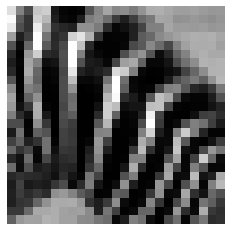

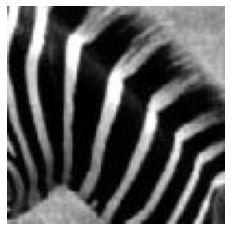

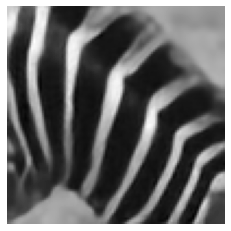

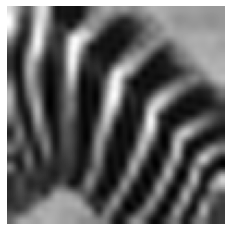

24.98227882385254
19.36557960510254
0.8917445540428162
0.6763765215873718


In [19]:
with open('/home/kouwsek/Documents/PW/SEM6/neural_network/data/set14/patch0/LR.pkl', 'rb') as file:
    train_x = pickle.load(file)
with open('/home/kouwsek/Documents/PW/SEM6/neural_network/data/set14/patch0/HR.pkl', 'rb') as file:
    train_y = pickle.load(file)
with torch.no_grad():
    upsample = nn.Upsample(scale_factor=4, mode='bicubic')
    output = network(train_x[34].view(1, 1, 25, 25).cuda())
    bicubic = upsample(train_x[34].view(1,1,25,25).cuda())
    plt.imshow(train_x[34].view(25, 25), cmap='gray')
    plt.axis('off')
    plt.show()
    plt.imshow(train_y[34].view(100, 100), cmap='gray')
    plt.axis('off')
    plt.show()
    plt.imshow(output.view(100, 100).cpu(), cmap='gray')
    plt.axis('off')
    plt.show()
    plt.imshow(bicubic.view(100, 100).cpu(), cmap='gray')
    plt.axis('off')
    plt.show()
    print(psnr.psnr(output, train_y[34].view(1, 1, 100, 100).cuda()).item())
    print(psnr.psnr(bicubic, train_y[34].view(1, 1, 100, 100).cuda()).item())
    print(ssim.ssim(output, train_y[34].view(1, 1, 100, 100).cuda()).item())
    print(ssim.ssim(bicubic, train_y[34].view(1, 1, 100, 100).cuda()).item())

26.43459701538086
0.8773143887519836


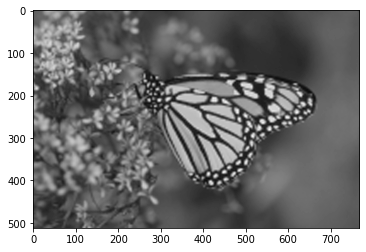

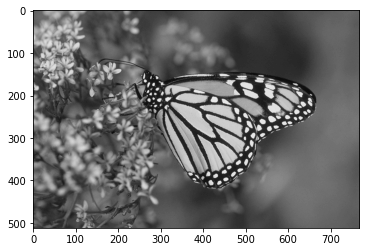

In [6]:
img = cv.imread('/home/kouwsek/Documents/PW/SEM6/neural_network/data/Set14/monarch.png', cv.IMREAD_COLOR)
img2 = cv.imread('/home/kouwsek/Downloads/DIV2K_valid_LR_bicubic/X4/0801x4.png', cv.IMREAD_COLOR)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2YUV)
img2 = img2.astype('float32')
img2 /= 255.0
y, u, v = cv.split(img2)
img2 = torch.from_numpy(y)
original2 = img2.reshape(1,1,img2.shape[0],img2.shape[1])

img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
img = img.astype('float32')
img /= 255.0
y, u, v = cv.split(img)
img = torch.from_numpy(y)

original = img.reshape(1,1,img.shape[0],img.shape[1])
if original.shape[2] % 4 is not 0:
    original = original.narrow(2, 0, original.shape[2] // 4 * 4)
if original.shape[3] % 4 is not 0:
    original = original.narrow(3, 0, original.shape[3] // 4 * 4)

# if original2.shape[2] % 4 is not 0:
#     original2 = original2.narrow(2, 0, original2.shape[2] // 4 * 4)
# if original2.shape[3] % 4 is not 0:
#     original2 = original2.narrow(3, 0, original2.shape[3] // 4 * 4)

img = original
img = F.interpolate(img, size=(img.shape[2]//4, img.shape[3]//4), mode='area')
img = F.interpolate(img, scale_factor=4, mode='bicubic')

img2 = F.interpolate(original2, scale_factor=4, mode='bicubic')
psnr1 = psnr.psnr(img, original)
#psnr2 = psnr.psnr(img2, original)
ssim1 = ssim.ssim(img, original)
print(psnr1.item())
#print(psnr2.item())
print(ssim1.item())
img = img.reshape(img.shape[2], img.shape[3])
plt.imshow(img, cmap='gray')
plt.show()
original = original.reshape(original.shape[2], original.shape[3])
plt.imshow(original, cmap='gray')
plt.show()

In [9]:
torch.save(network.state_dict(), 'data/SR-SLNN')

In [3]:
device = torch.device("cuda")
network = Net()
network.load_state_dict(torch.load('/home/kouwsek/Documents/PW/SEM6/neural_network/data/SR-SLNN', map_location="cuda:0"))
network.to(device)
network.eval()

Net(
  (upsample): Upsample(scale_factor=4.0, mode=bicubic)
  (conv1): _conv_node(
    (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu): ReLU(inplace=True)
  )
  (dense1): _dense_block(
    (conv0): _conv_node(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (conv1): _conv_node(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
  )
  (conv4): _conv_node(
    (conv): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (deconv): Sequential(
    (conv5): _conv_node(
      (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (deconv1): _deconv_node(
      (deconv): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu): ReLU(inplace=True)
    )
    (deconv2): _deconv_node(
      (de

In [7]:
val_psnr = list()
val_ssim = list()
psnr_score = psnr.PSNR()
ssim_score = ssim.SSIM()
if torch.cuda.is_available():
    psnr_score = psnr_score.cuda()
    ssim_score = ssim_score.cuda()

for subdir in os.listdir('data/set14'):
    path = os.path.join('data/set14', subdir)
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if filename.endswith("LR.pkl"):
            with open(file_path, 'rb') as file:
                val_x = pickle.load(file)
        elif filename.endswith("HR.pkl"):
            with open(file_path, 'rb') as file:
                val_y = pickle.load(file)
    val_ssim.append(validate_ssim(val_x, val_y))
    val_psnr.append(validate(val_x, val_y))

print(val_psnr)
print(val_ssim)

/home/kouwsek/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


[27.651452905991498]
[0.7648098811726359]


In [4]:
HR_images1 = list()
HR_images2 = list()

for image in os.listdir('data/BSD100'):
    path = os.path.join('data/BSD100', image)
    img = cv.imread(path, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2YUV)
    img = img.astype('float32')
    img /= 255.0
    y, u, v = cv.split(img)
    HR_images1.append(y)
for image in HR_images1:
    img = torch.from_numpy(image)
    img = img.reshape(1, 1, img.shape[0], img.shape[1])
    HR_images2.append(img)

In [4]:
for subdir in os.listdir('data/bsd100'):
    path = os.path.join('data/bsd100', subdir)
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if filename.endswith("HR.pkl"):
            with open(file_path, 'rb') as file:
                val_x = pickle.load(file)

In [7]:
dummy_input = torch.randn(1, 1, 224, 224, dtype=torch.float).to(device)

# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = len(HR_images2)
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = network(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        if torch.cuda.is_available():
            img = HR_images2[rep].cuda()
            #img = img.reshape(1 , img.shape[0], img.shape[1], img.shape[2])
        starter.record()
        _ = network(img)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)
print(repetitions)

75.179820022583
100


In [6]:
for subdir in os.listdir('data/set14'):
    path = os.path.join('data/set14', subdir)
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if filename.endswith("LR.pkl"):
            with open(file_path, 'rb') as file:
                val_x = pickle.load(file)
        elif filename.endswith("HR.pkl"):
            with open(file_path, 'rb') as file:
                val_y = pickle.load(file)



In [14]:
network.eval()
with torch.no_grad():
    for i, x in enumerate(HR_images2):
        if i == 9:
            break
        #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        if torch.cuda.is_available():
            x = x.cuda()
        network(x)
        print(torch.cuda.max_memory_allocated()/1024/1024)
        break

256.734375
256.734375
2256.24365234375


In [4]:
dummy_input = torch.randn(1, 1, 100, 100, dtype=torch.float).to(device)
for _ in range(10):
    _ = network(dummy_input)
    print(torch.cuda.max_memory_allocated()/1024/1024)

63.62841796875
63.62841796875
63.62841796875
63.62841796875
63.62841796875
63.62841796875
63.62841796875
63.62841796875
63.62841796875
63.62841796875


/home/kouwsek/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


/home/kouwsek/.local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


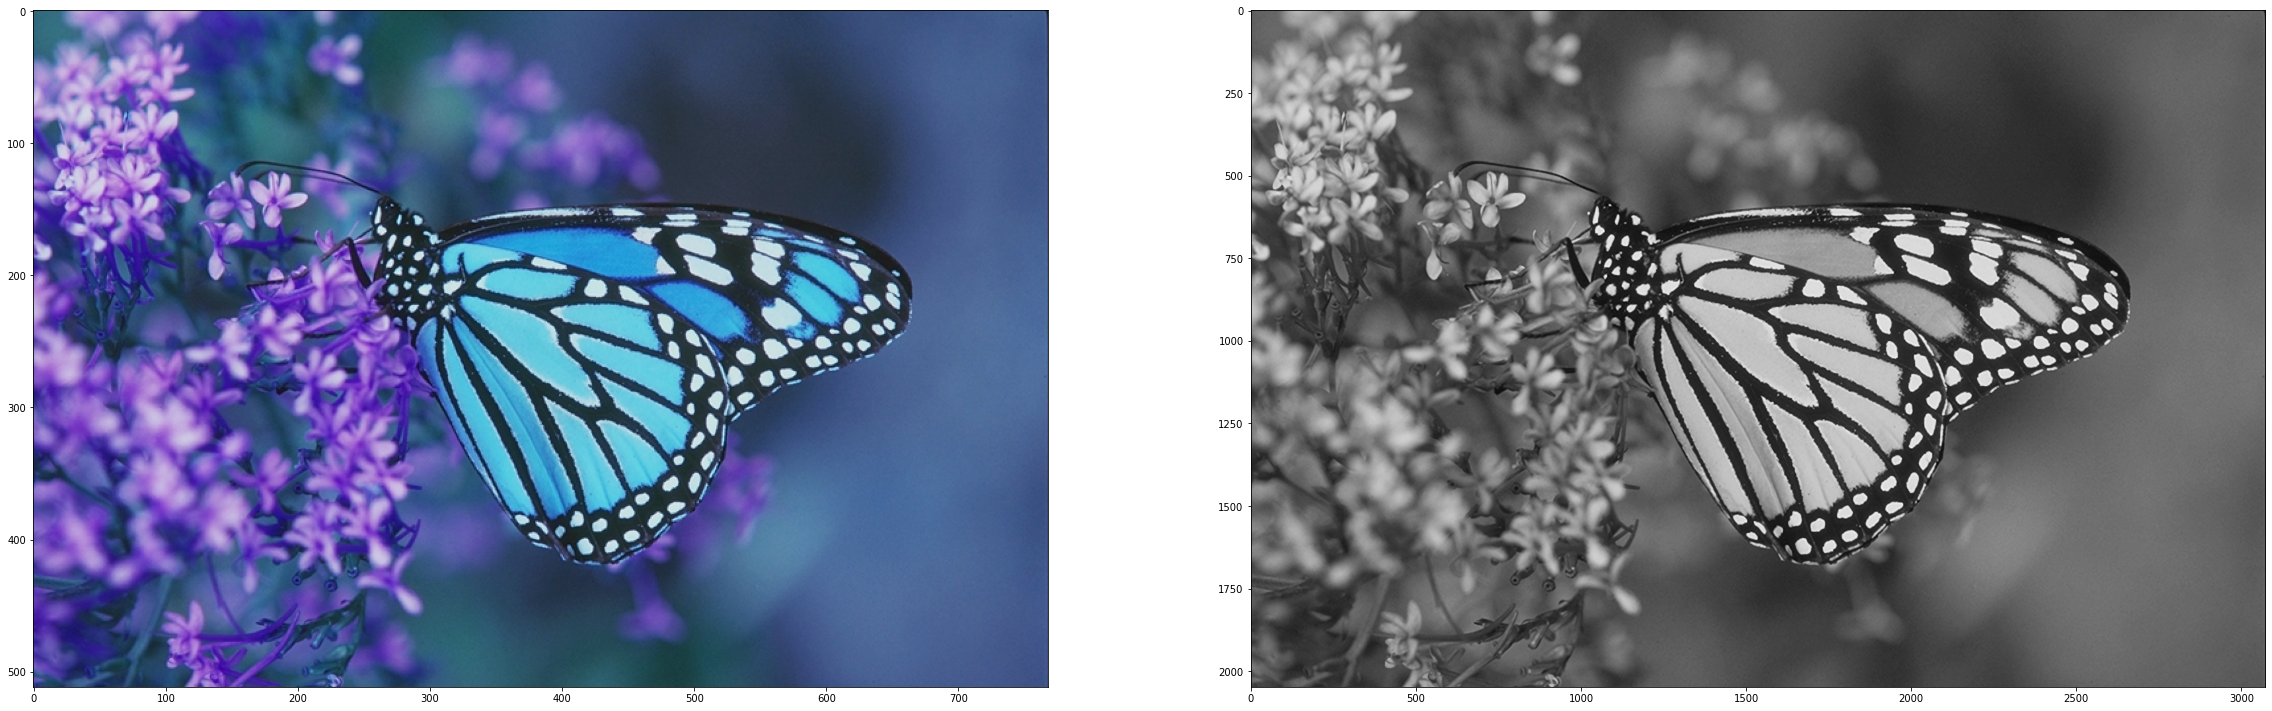

In [31]:
original = cv.imread('/home/kouwsek/Documents/PW/SEM6/neural_network/data/Set14/monarch.png', cv.IMREAD_COLOR)
img = cv.cvtColor(original, cv.COLOR_BGR2YUV)
img = img.astype('float32')
img /= 255.0
y, u, v = cv.split(img)
img = torch.from_numpy(y)
img = img.reshape(1,1,img.shape[0],img.shape[1])

#for x in range(2):
img = network(img.cuda())

img *= 255.0

with torch.no_grad():
    cv.imwrite('/home/kouwsek/Documents/PW/SEM6/neural_network/monarch1.png', np.float32(img.view(img.shape[2], img.shape[3]).cpu()))
    plt.figure(figsize=(40,40))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(img.view(img.shape[2], img.shape[3]).cpu(), cmap='gray')
    

24.99341583251953
0.9080384969711304


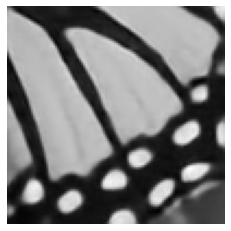

20.483598709106445
0.7362736463546753


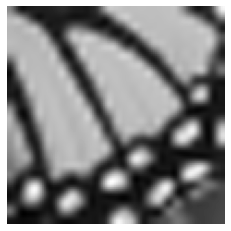

In [16]:
with open('/home/kouwsek/Documents/PW/SEM6/neural_network/data/set14/patch0/LR.pkl', 'rb') as file:
    train_x = pickle.load(file)
with open('/home/kouwsek/Documents/PW/SEM6/neural_network/data/set14/patch0/HR.pkl', 'rb') as file:
    train_y = pickle.load(file)
with torch.no_grad():
    for i in range(len(train_x)):
        if i == 65:
            upsample = nn.Upsample(scale_factor=4, mode='bicubic')
            output = network(train_x[i].view(1, 1, 25, 25).cuda())
            bicubic = upsample(train_x[i].view(1,1,25,25).cuda())
            psnr1 = psnr.psnr(output, train_y[i].view(1, 1, 100, 100).cuda()).item()
            ssim1 = ssim.ssim(output, train_y[i].view(1, 1, 100, 100).cuda()).item()
            print(psnr1)
            print(ssim1)
            #plt.figure(figsize=(15,15))
            #plt.subplot(1, 2, 1)
            #plt.title(f'psnr: {psnr1}, ssim: {ssim1}')
            plt.axis('off')
            plt.imshow(output.view(100, 100).cpu(), cmap='gray')
            plt.show()
            #plt.subplot(1, 2, 2)
            psnr1 = psnr.psnr(bicubic, train_y[i].view(1, 1, 100, 100).cuda()).item()
            ssim1 = ssim.ssim(bicubic, train_y[i].view(1, 1, 100, 100).cuda()).item()
            print(psnr1)
            print(ssim1)
            plt.axis('off')
            #plt.title(f'psnr: {psnr1}, ssim: {ssim1}')
            plt.imshow(bicubic.view(100, 100).cpu(), cmap='gray')
            plt.show()